Initial Omega_rc: [[0 9]
 [9 0]
 [5 5]]


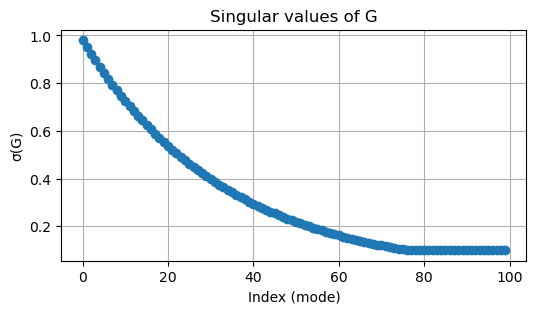

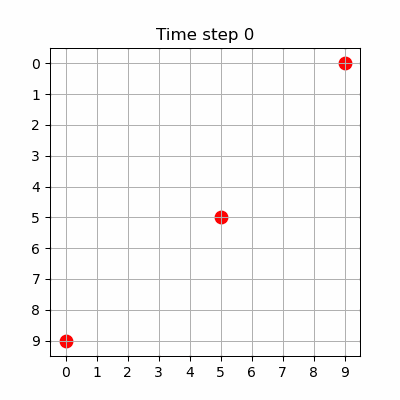

Single run results: {'err': 0.4938680769855759, 'rank': 70, 'sigma_min': 3.826397360293108e-22, 'cond': 2.624416262977593e+21}


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, display

# ============================================================
# Parameters (EXPERIMENT CONTROLS)
# ============================================================
H, W = 10, 10
n = H * W

rng = np.random.default_rng(0)

# Initial robot positions (row, col)
Omega0_rc = np.array([
    [0, W - 1],
    [H - 1, 0],
    [H // 2, W // 2]
])
m = Omega0_rc.shape[0]
print("Initial Omega_rc:", Omega0_rc)

# ============================================================
# Helper: indexing and selector matrix P_t
# ============================================================
def rc_to_idx(r, c, W):
    return r * W + c

def selector_from_rc(Omega_rc, H, W):
    n = H * W
    m = Omega_rc.shape[0]
    P = np.zeros((m, n))
    for row, (r, c) in enumerate(Omega_rc):
        P[row, rc_to_idx(r, c, W)] = 1.0
    return P

# ============================================================
# FIX G + specify singular values (advisor request)
# ============================================================
def make_orthonormal_matrix(n, rng):
    A = rng.normal(size=(n, n))
    Q, _ = np.linalg.qr(A)
    return Q

def singular_value_profile(n, kind="exp_decay", top=0.98, tail=0.10, alpha=0.03):
    """
    Returns svals of length n.
    'where they are located' = by index:
      - svals[0] is the largest singular value mode,
      - svals[-1] is the smallest mode.
    """
    if kind == "flat":
        s = np.full(n, top)
    elif kind == "two_level":
        # first k are large, rest smaller
        k = max(1, n // 10)
        s = np.full(n, tail)
        s[:k] = top
    elif kind == "exp_decay":
        i = np.arange(n)
        s = top * np.exp(-alpha * i)
        s = np.maximum(s, tail)
    else:
        raise ValueError("Unknown kind")
    return s

def make_G_from_singular_values(n, svals, rng):
    """
    G = U diag(s) V^T with chosen singular values s.
    This directly enforces the singular spectrum you want.
    """
    U = make_orthonormal_matrix(n, rng)
    V = make_orthonormal_matrix(n, rng)
    G = U @ np.diag(svals) @ V.T
    return G

# ---- Build G ONCE (fixed across experiments) ----
svals_target = singular_value_profile(
    n,
    kind="exp_decay",   # try: "flat", "two_level", "exp_decay"
    top=0.98,           # largest singular value
    tail=0.10,          # minimum singular value floor
    alpha=0.03
)
G = make_G_from_singular_values(n, svals_target, rng)

# Visualize singular values of G (advisor request)
sG = np.linalg.svd(G, compute_uv=False)
plt.figure(figsize=(6,3))
plt.plot(sG, marker='o', linewidth=1)
plt.title("Singular values of G")
plt.xlabel("Index (mode)")
plt.ylabel("σ(G)")
plt.grid(True)
plt.show()

# ============================================================
# Parametrize robot movement (advisor request)
# ============================================================
def snake_path_coords(H, W, direction="down", start_side="right"):
    """
    Returns a Hamiltonian 'snake' path visiting each grid cell once.
    direction: "down" or "up" (scan order)
    start_side: "left" or "right" (starting side in the first row of the scan)
    """
    rows = range(H) if direction == "down" else range(H-1, -1, -1)
    coords = []
    for rr_i, r in enumerate(rows):
        # choose left->right or right->left alternating
        if (rr_i % 2 == 0 and start_side == "left") or (rr_i % 2 == 1 and start_side == "right"):
            cols = range(W)
        else:
            cols = range(W-1, -1, -1)
        for c in cols:
            coords.append((r, c))
    return coords

def move_policy_parametric(Omega_rc, t, H, W, rng, policy):
    """
    policy dict example:
      {
        "type": "snake",          # "snake" or "random_walk"
        "direction": "down",      # for snake
        "start_side": "right",    # for snake
        "step": 1,                # how many path indices to advance per time
        "phases": [0, 30, 55],    # per-robot offsets along the path
        "p_random": 0.0           # chance to take random move instead (hybrid)
      }
    """
    Omega_next = Omega_rc.copy()
    m = Omega_rc.shape[0]

    if policy["type"] == "snake":
        path = policy["_path"]  # precomputed list of (r,c)
        L = len(path)
        step = int(policy.get("step", 1))
        phases = policy.get("phases", [0]*m)
        p_random = float(policy.get("p_random", 0.0))

        # map current positions to indices along the path (precompute once for speed)
        idx_map = policy["_idx_map"]  # dict {(r,c): idx}

        for i in range(m):
            r, c = Omega_rc[i]
            if rng.random() < p_random:
                # random move (optional)
                dr, dc = rng.choice([(0,0),(1,0),(-1,0),(0,1),(0,-1)])
                r_new = min(max(r+dr, 0), H-1)
                c_new = min(max(c+dc, 0), W-1)
                Omega_next[i] = [r_new, c_new]
                continue

            cur_idx = idx_map[(r, c)]
            new_idx = (cur_idx + step) % L
            # apply phase offset by re-indexing the path position
            phased_idx = (new_idx + phases[i]) % L
            Omega_next[i] = path[phased_idx]

        return Omega_next

    elif policy["type"] == "random_walk":
        for i, (r, c) in enumerate(Omega_rc):
            dr, dc = rng.choice([(0,0),(1,0),(-1,0),(0,1),(0,-1)])
            r_new = min(max(r+dr, 0), H-1)
            c_new = min(max(c+dc, 0), W-1)
            Omega_next[i] = [r_new, c_new]
        return Omega_next

    else:
        raise ValueError("Unknown policy type")

# ============================================================
# Simulation + reconstruction in a function (so we can sweep)
# ============================================================
def run_simulation(G, H, W, Omega0_rc, T, noise_level, rng, policy, make_gif=False, gif_name="robots.gif"):
    n = H * W
    m = Omega0_rc.shape[0]

    # initial state (normalized)
    v0_true = rng.normal(size=n)
    v0_true /= np.linalg.norm(v0_true)
    v_t = v0_true.copy()

    # policy precompute (snake path + index map)
    if policy["type"] == "snake":
        path = snake_path_coords(H, W, direction=policy.get("direction","down"), start_side=policy.get("start_side","right"))
        idx_map = {rc: i for i, rc in enumerate(path)}
        policy = dict(policy)  # copy
        policy["_path"] = path
        policy["_idx_map"] = idx_map

        # ensure phases length = m
        phases = policy.get("phases", [0]*m)
        if len(phases) != m:
            phases = (phases + [0]*m)[:m]
        policy["phases"] = phases

    Omega_rc = Omega0_rc.copy()

    O_blocks, ys, positions = [], [], []
    G_power = np.eye(n)

    for t in range(T + 1):
        positions.append(Omega_rc.copy())

        P_t = selector_from_rc(Omega_rc, H, W)
        y_t = P_t @ v_t + rng.normal(scale=noise_level, size=m)
        ys.append(y_t)

        # O_t = P_t G^t
        if t == 0:
            O_blocks.append(P_t @ G_power)
        else:
            G_power = G_power @ G
            O_blocks.append(P_t @ G_power)

        v_t = G @ v_t
        Omega_rc = move_policy_parametric(Omega_rc, t, H, W, rng, policy)

    y_stacked = np.concatenate(ys, axis=0)
    O_T = np.vstack(O_blocks)

    v0_hat, *_ = np.linalg.lstsq(O_T, y_stacked, rcond=None)
    err = np.linalg.norm(v0_hat - v0_true)

    rank = np.linalg.matrix_rank(O_T)
    sO = np.linalg.svd(O_T, compute_uv=False)
    sigma_min = sO[-1]
    cond = (sO[0] / sO[-1]) if sigma_min > 0 else np.inf

    # optional GIF
    if make_gif:
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.set_xlim(-0.5, W - 0.5)
        ax.set_ylim(H - 0.5, -0.5)
        ax.set_xticks(range(W))
        ax.set_yticks(range(H))
        ax.grid(True)
        scat = ax.scatter([], [], s=80, c="red")

        def init():
            scat.set_offsets(np.empty((0, 2)))
            return (scat,)

        def update(frame):
            Omega = positions[frame]
            xy = np.column_stack([Omega[:, 1], Omega[:, 0]])
            scat.set_offsets(xy)
            ax.set_title(f"Time step {frame}")
            return (scat,)

        ani = animation.FuncAnimation(fig, update, frames=len(positions), init_func=init, interval=250, blit=True)
        ani.save(gif_name, writer=animation.PillowWriter(fps=4))
        plt.close(fig)

        display(Image(filename=gif_name))

    return {
        "err": err,
        "rank": rank,
        "sigma_min": sigma_min,
        "cond": cond
    }

# ============================================================
# 1) Single run (like your original), but parameterized
# ============================================================
policy_snake = {
    "type": "snake",
    "direction": "down",
    "start_side": "right",
    "step": 1,
    "phases": [0, 25, 50],
    "p_random": 0.0
}

res = run_simulation(
    G=G,
    H=H, W=W,
    Omega0_rc=Omega0_rc,
    T=200,
    noise_level=0.0,
    rng=np.random.default_rng(1),   # separate RNG for sim so results are stable
    policy=policy_snake,
    make_gif=True,
    gif_name="robots_parametric.gif"
)
print("Single run results:", res)

# ============================================================
# 2) How reconstruction error changes (sweeps)
# ============================================================
Ts = [20, 50, 100, 200]
noises = [0.0, 0.01, 0.05]

policies = {
    "snake_step1": dict(policy_snake, step=1, p_random=0.0),
    "snake_step2": dict(policy_snake, step=2, p_random=0.0),
    "snake_hybrid": dict(policy_snake, step=1, p_random=0.2),
    "random_walk": {"type": "random_walk"}
}

# print("\nSweep summary (err, rank, sigma_min, cond):")
# for name, pol in policies.items():
#     for T in Ts:
#         for nl in noises:
#             out = run_simulation(
#                 G=G, H=H, W=W,
#                 Omega0_rc=Omega0_rc,
#                 T=T,
#                 noise_level=nl,
#                 rng=np.random.default_rng(2),  # keep same for fair comparisons
#                 policy=pol,
#                 make_gif=False
#             )
#             print(f"{name:12s}  T={T:3d}  noise={nl:0.2f}  "
#                   f"err={out['err']:.3e}  rank={out['rank']:3d}  "
#                   f"smin={out['sigma_min']:.3e}  cond={out['cond']:.3e}")